# <center>Lab 3: Data Standardization, Logistic Regression, Line Search</center>
<center>DATA 558, Spring 2021</center>
<center>TAs: Alec Greaves-Tunnell and Ronak Mehta</center>

## 0. Overview

In this lab, we will cover:
- Standardization of regression data - when, why, and how
- The appropriate way to standardize with train / test splits
- Transformation back to the original scale
- Regularized logistic regression
- Measurement of classification error
- Adaptive step sizes for gradient descent via line search

In [1]:
import sklearn
import numpy as np
import pandas as pd

## 1. Data standardization

We'll begin by taking a closer, more mathematically motivated look at the practice of data standardization. Up to now this has been encouraged as a default practice without much explanation - here we will explore some specific reasons motivating this procedure.

Standardization refers to the mathematical operation whereby a column is _centered_ such that its mean is zero and _scaled_ such that its variance is one. This is accomplished by subtracting the mean and dividing by the standard deviation:

$$
x_S = \frac{x-\frac{1}{n}\sum_{i=1}^n x_i}{\sqrt{\frac{1}{n}(x- \frac{1}{n}\sum_{i=1}^n x_i)^2}}
$$

Some observations:
- Standardization is a *linear* operation: it consists of shifting and scaling the data by constant values.
- It is *invertible*: if we standardize a column (and remember to store the mean and standard deviation somewhere), we can convert back to the original scale by reversing this procedure (i.e. multiplying by the std. dev. and adding the mean).
- Standardized columns have mean 0 and variance (or norm) 1.

We'll investigate the benefits of standardization by considering the effects of centering and scaling separately.

### 1.1 Centering data

In the context of regression, the main benefit of centering data is that it allows us to ignore the question of whether we include an intercept in the model. To see why, let's consider the linear model

$$
y = \beta_0 + x^T \beta + \varepsilon.
$$

Given a set of observations $\{(y_i, x_i)\}_{i=1}^n$, we compute an estimate of the intercept $\hat{\beta}_0$ and the coefficients $\hat{\beta}$ by minimizing the OLS objective:

$$
\hat{\beta}_0, \hat{\beta} = \text{argmin}_{\beta_0, \beta} \frac{1}{2n} \sum_{i=1}^n (y_i - \beta_0 - x_i^T \beta)^2.
$$

The minimum is achieved at the value of $(\beta_0, \beta)$ for which all partial derivatives are equal to zero. In particular we have

\begin{align*}
\frac{\partial}{\partial \beta_0}\sum_{i=1}^n (y_i - \hat{\beta}_0 - x_i^T \hat{\beta})^2 &= -\frac{1}{n}\sum_{i=1}^n (y_i - \hat{\beta}_0 - x_i^T \hat{\beta}) \\
&= -\bar{y} + \hat{\beta}_0 + \bar{x}^T \hat{\beta} \\
&= 0,
\end{align*}

where

$$
\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i \text{ and } \bar{x} = \frac{1}{n} \sum_{i=1}^n x_i.
$$

Solving for $\hat{\beta}_0$ yields

$$
\hat{\beta}_0 = \bar{y} - \bar{x}^T\hat{\beta},
$$

and from this fact we derive the following two insights:
1. When the features are centered, the intercept is equal to the mean of the outcome.
2. When both the features and outcome are centered, the intercept is zero.

Let's show this on real data. As a running example in this section, we'll use the California Housing dataset (originally from http://lib.stat.cmu.edu/datasets/). The data consist one outcome (median home value) and 8 numeric predictors measured per-block in the 1990 U.S. Census.

In [2]:
from sklearn.linear_model import Ridge, LinearRegression

In [3]:
df = pd.read_csv('./cal_housing_data.csv')
df.head()

,MedianValue,MedianInc,MedianHouseAge,TotalRooms,TotalBedrooms,Population,NumHouseholds,Latitude,Longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


In [4]:
X = df.iloc[:, 1:]
print('Features: {}'.format(list(X.columns)))
y = df.iloc[:, 0]
print('Target: {}'.format(y.name))

Features: ['MedianInc', 'MedianHouseAge', 'TotalRooms', 'TotalBedrooms', 'Population', 'NumHouseholds', 'Latitude', 'Longitude']
Target: MedianValue


In [5]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X,y) # no centering

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
lr.intercept_

-3594022.9418763956

In [7]:
pd.DataFrame({x: [y] for (x,y) in zip(X.columns, lr.coef_)})

,Latitude,Longitude,MedianHouseAge,MedianInc,NumHouseholds,Population,TotalBedrooms,TotalRooms
0,-42576.721912,-42823.743794,1156.303866,40248.514216,48.308287,-38.535095,113.410689,-8.181649


Now let's center the features.

In [8]:
Xc = X-X.mean(axis=0)

In [9]:
lr.fit(Xc,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
lr.intercept_

206855.81690878686

In [11]:
y.mean() # intercept is the mean of the outcome

206855.81690891474

In [12]:
pd.DataFrame({x: [y] for (x,y) in zip(X.columns, lr.coef_)}) # coefficients are unchanged

,Latitude,Longitude,MedianHouseAge,MedianInc,NumHouseholds,Population,TotalBedrooms,TotalRooms
0,-42576.721912,-42823.743794,1156.303866,40248.514216,48.308287,-38.535095,113.410689,-8.181649


Finally, we'll fit the model after centering both X and y.

In [13]:
yc = y-y.mean()

In [14]:
lr.fit(Xc,yc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
lr.intercept_

-1.2789142961456252e-07

In [16]:
pd.DataFrame({x: [y] for (x,y) in zip(X.columns, lr.coef_)}) # coefficients are unchanged

,Latitude,Longitude,MedianHouseAge,MedianInc,NumHouseholds,Population,TotalBedrooms,TotalRooms
0,-42576.721912,-42823.743794,1156.303866,40248.514216,48.308287,-38.535095,113.410689,-8.181649


__Exercise 1.1__: Repeat the above sequence for ridge regression with some large-enough value of $\lambda$ (say, $\lambda = 1000$). Does anything change? Why or why not?

In [19]:
'''
Solution:

We fit the ridge model before and after centering.
The intercept is unchanged versus the linear model,
even with strong regularization. To see why this is 
the case, consider that adding a regularization term
to the slope parameters doesn't change the gradient
of the loss with respect to the intercept, and thus doesn't
change the optimal value of the intercept parameter.
'''
rr = Ridge(alpha=1000).fit(X,y)
print('Ridge intercept, no centering: {:.3f}'.format(rr.intercept_))

Ridge intercept, no centering: -3031191.376


In [22]:
rr = Ridge(alpha=1000).fit(Xc,yc)
print('Ridge intercept after centering: {}'.format(rr.intercept_))

Ridge intercept after centering: -1.0803092719299234e-07


### 1.2 Scaling

In contrast to centering, the benefits of scaling the data are somewhat more diverse. At a high level, they all correspond to improving the "conditioning" of the least squares problem. 

We will examine three results of scaling in detail:
1. Standardization eliminates sensitivity of penalty terms to the units of the features, and ensures that the regression parameters are penalized equally.
2. Standardization improves the behavior of gradient descent and enables generic choices of the step size.
3. Standardization stabilizes numerical operations such as computation of the inverse.


_Effect of scaling on penalization_.

Penalty functions, such as the $\ell$2 penalty of ridge regression, often implicitly assume that each feature is measured on the same scale.

In [18]:
%%capture
!pip install statsmodels

In [19]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
lm = smf.ols(formula='MedianValue ~ MedianInc + Population', data=df)
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MedianValue   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     9307.
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:18:57   Log-Likelihood:            -2.6323e+05
No. Observations:               20640   AIC:                         5.265e+05
Df Residuals:                   20637   BIC:                         5.265e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.912e+04   1508.852     32.553      0.000    4.62e+04    5.21e+04
MedianInc    4.18e+04    306.589    136.346      0.000    4.12e+04    4.24e+04
Population    -2.8508      0.514     -5.543      0.000      -3.859      -1.843
==============================================================================
Omnibus:                     4177.333   Durbin-Watson:                   0.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9071.344
Skew:                           1.176   Prob(JB):                         0.00
Kurtosis:                       5.241   Cond. No.                     4.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
list(np.linalg.norm(X, axis=0))

[619.4539762875123,
 4494.272466150667,
 491549.9629335761,
 98154.19390428512,
 261551.25015568172,
 90373.83836597846,
 5128.285781291835,
 17180.54589953998]

In [22]:
X.head()

,MedianInc,MedianHouseAge,TotalRooms,TotalBedrooms,Population,NumHouseholds,Latitude,Longitude
0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


In [23]:
X2 = X.copy()
X2['Population'] = X2['Population']*1000

In [24]:
Xsmall = X2[['MedianInc', 'Population']]
Xsc = Xsmall-Xsmall.mean(axis=0)

In [25]:
lr = LinearRegression() # no penalization
lr.fit(Xsc, yc)
pd.DataFrame({x: [y] for (x,y) in zip(Xsmall.columns, lr.coef_)})[Xsmall.columns]

,MedianInc,Population
0,41802.064268,-0.002851


In [26]:
rr = Ridge(alpha=100000) # penalized model on unscaled data
rr.fit(Xsc, yc)

Ridge(alpha=100000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [27]:
pd.DataFrame({x: [y] for (x,y) in zip(Xsmall.columns, rr.coef_)})[Xsmall.columns]

,MedianInc,Population
0,17845.500243,-0.002656


In [28]:
Xss = Xsc / Xsc.std(axis=0)
yss = yc / yc.std(axis=0)

In [29]:
lr = LinearRegression() # coefficients are now on a similar scale
lr.fit(Xss, yss)
pd.DataFrame({x: [y] for (x,y) in zip(Xsmall.columns, lr.coef_)})[Xsmall.columns]

,MedianInc,Population
0,0.68821,-0.027977


In [30]:
rr = Ridge(alpha=10000) # penalization affects both coefficients
rr.fit(Xss, yss)
pd.DataFrame({x: [y] for (x,y) in zip(Xsmall.columns, rr.coef_)})[Xsmall.columns]

,MedianInc,Population
0,0.463559,-0.018114


_Effect of scaling on gradient descent_.

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
def generate_data1(n, d, scale, beta):
    X = np.random.normal(size=(n,d))
    X[:, 0] = X[:, 0] * scale    
    y = np.dot(X, beta) + np.random.normal(size=n)
    
    return X, y

def generate_data2(n, d, scale, beta):
    std = np.diag(np.arange(d))
    X = np.random.normal(size=(n,d))
    X = np.dot(X, std)
    # X[:, :5] = X[:, :5] * scale    
    # X[:, -5:] = X[:, -5:] / scale    
    y = np.dot(X, beta) + np.random.normal(size=n)
    
    return X, y
    
def obj(beta, X, y):
    return np.mean((y-np.dot(X, beta))**2)

def plot_objective(X, y, iterates=None, levels=None):
    nb = 100
    brange = np.linspace(-10, 10, nb)
    b1, b2 = np.meshgrid(brange, brange)
    z = np.array([obj(x, X, y) for x in zip(b1.ravel(), b2.ravel())])
    
    if levels is None:
        levels=np.logspace(-2,4,30)
    
    plt.contour(brange, brange, z.reshape((nb, nb)), levels=levels);
    
    if iterates is not None:
        # Points.
        plt.plot(iterates[:,0], iterates[:,1], 'k.');
        
        # Arrows.
        for j in range(1, len(iterates)):
            plt.annotate(
                "",
                xy=iterates[j],
                xytext=iterates[j - 1],
                arrowprops={"arrowstyle": "->", "color": "k", "lw": 1},
                va="center",
                ha="center",
            )

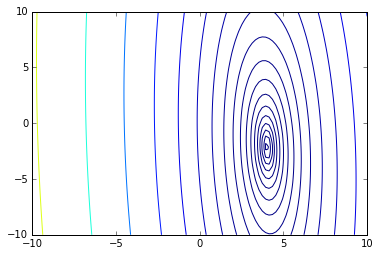

In [45]:
np.random.seed(123)

n = 20
d = 2
scale = 5
beta = np.array([4.0, -2.0])

X, y = generate_data1(n, d, scale, beta)
plot_objective(X, y)

In [46]:
def computegrad(beta, X, y):
    n = len(X)
    return -2/n * np.dot(X.T, y-np.dot(X, beta))

def graddescent(beta_init, eta, X, y, max_iter=20):
    """Run gradient descent with a fixed step size
    Inputs:
    - beta_init: Starting point
    - eta: Step size (a constant)
    - max_iter: Maximum number of iterations to perform
    Output:
    - beta_vals: Matrix of estimated betas at each iteration,
                with the most recent values in the last row.
    """
    beta = beta_init
    grad_beta = computegrad(beta, X=X, y=y)
    beta_vals = [beta]
    iter_num = 0
    while iter_num < max_iter:
        beta = beta - eta*grad_beta
        beta_vals.append(beta)
        grad_beta = computegrad(beta, X=X, y=y)
        iter_num += 1
        
    return np.array(beta_vals)

In [47]:
beta_init = np.array([-5, 8])
eta = 0.01
iterates = graddescent(beta_init, eta, X, y)

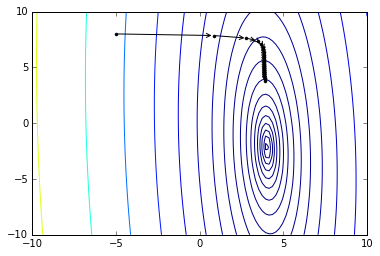

In [48]:
plot_objective(X, y, iterates=iterates)

In [49]:
# now standardize
Xs = (X-X.mean(axis=0)) / np.std(X, axis=0)
ys = y / np.std(y, axis=0)

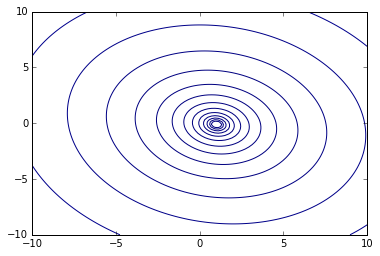

In [50]:
plot_objective(Xs, ys, levels=np.logspace(-1,4,20))

In [51]:
beta_init = np.array([-5, 8])
eta = 0.1
iterates = graddescent(beta_init, eta, X=Xs, y=ys)

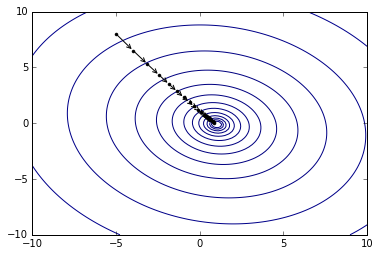

In [52]:
plot_objective(Xs, ys, iterates=iterates, levels=np.logspace(-1,4,20))

__Exercise 1.2__: Add a ridge regression penalty to the objective function, and implement the corresponding gradient (you may reuse code from previous labs or homeworks). What is the effect on the shape of the contour plot versus the unregularized version?

In [53]:
# ridge objective and gradient
def ridge_obj(beta, lam, X, y):
    return 1/(2*len(X))*sum((y-X.dot(beta))**2) + lam/len(X)*np.linalg.norm(beta)**2

def computegrad(beta, lam, X, y):
    resid = y-np.dot(X, beta)
    n = len(X)
    return -1/n*X.T.dot(resid) + 2/n*lam*beta

In [56]:
# also need to modify grad descent and plotting functions
def graddescent(beta_init, eta, lam, X, y, max_iter=20):
    """Run gradient descent with a fixed step size
    Inputs:
    - beta_init: Starting point
    - eta: Step size (a constant)
    - max_iter: Maximum number of iterations to perform
    Output:
    - beta_vals: Matrix of estimated betas at each iteration,
                with the most recent values in the last row.
    """
    beta = beta_init
    grad_beta = computegrad(beta, lam, X, y)
    beta_vals = [beta]
    iter_num = 0
    while iter_num < max_iter:
        beta = beta - eta*grad_beta
        beta_vals.append(beta)
        grad_beta = computegrad(beta, lam, X, y)
        iter_num += 1
        
    return np.array(beta_vals)

def plot_ridge_objective(X, y, lam, iterates=None, levels=None):
    nb = 100
    brange = np.linspace(-10, 10, nb)
    b1, b2 = np.meshgrid(brange, brange)
    z = np.array([ridge_obj(x, lam, X, y) for x in zip(b1.ravel(), b2.ravel())])
    
    if levels is None:
        levels=np.logspace(-2,4,30)
    
    plt.contour(brange, brange, z.reshape((nb, nb)), levels=levels);
    
    if iterates is not None:
        # Points.
        plt.plot(iterates[:,0], iterates[:,1], 'k.');
        
        # Arrows.
        for j in range(1, len(iterates)):
            plt.annotate(
                "",
                xy=iterates[j],
                xytext=iterates[j - 1],
                arrowprops={"arrowstyle": "->", "color": "k", "lw": 1},
                va="center",
                ha="center",
            )

In [61]:
lam = 100.0

beta_init = np.array([-5, 8])
eta = 0.01
iterates = graddescent(beta_init, eta, lam, X, y)

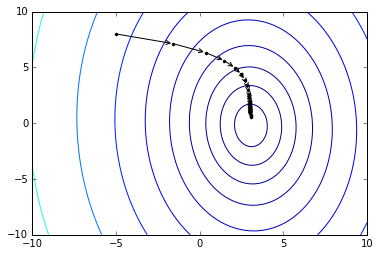

In [62]:
plot_ridge_objective(X, y, lam, iterates=iterates) # easier to find the minimum, even on unscaled X / y!

_Effect of scaling on numerical procedures_.

In [41]:
np.random.seed(123)

n = 5000
d = 30
scale = 1000000
beta = np.random.normal(size=d) + 5.0

X, y = generate_data2(n, d, scale, beta)

In [42]:
# linear regression coefficients via explicit formula (numerically unstable)
b = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
b

LinAlgError: Singular matrix

In [92]:
# coefficients via stable least squares solver
c = LinearRegression().fit(X,y).coef_
c

array([-7.36485103e-16,  6.01183149e+00,  5.28153587e+00,  3.49580256e+00,
        4.41490708e+00,  6.64867131e+00,  2.57589685e+00,  4.56933905e+00,
        6.26486318e+00,  4.13378646e+00,  4.31854616e+00,  4.90569908e+00,
        6.49247485e+00,  4.36004420e+00,  4.55454013e+00,  4.56568117e+00,
        7.20431242e+00,  7.18589388e+00,  6.00361594e+00,  5.38629504e+00,
        5.73663622e+00,  6.49128481e+00,  4.06389052e+00,  6.17627677e+00,
        3.74565696e+00,  4.36373176e+00,  5.90576985e+00,  3.57157154e+00,
        4.86069843e+00,  4.13871296e+00])

### 1.3 Further considerations

We include two final topics for this section:
1. The appropriate method for standardization of a train / test split.
2. Converting data back to the original scale.


__Standardizing with a train / test split__

Standardization can be viewed as a data transformation with two parameters, one for centering and the other for scaling. Importantly, this procedure is itself part of the data analysis, and so the "estimation" of these parameters should be conducted *__on the training data alone__*. In machine learning terms, the standardization parameters are "learned" on the train data and then applied to the test data before prediction at test time. 

In practice, this corresponds to the following procedure:
- Split the data into train and test sets.
- Compute the column-wise means and standard deviation of the train features and outcome.
- Standardize the train features and outcome in the usual way.
- Standardize the test features and outcome using the means and standard deviations estimated from the train set, __not__ their own means and standard deviations.

The scikit-learn API reflects the perspective on standardization as a learned transformation: 

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [94]:
df = pd.read_csv('./cal_housing_data.csv') # back to cal housing data
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [96]:
def standardize(X_train, y_train, X_test=None, y_test=None):
    Xscaler = StandardScaler().fit(X_train)
    X_train_std = Xscaler.transform(X_train)
    

    Yscaler = StandardScaler().fit(y_train[:, None])
    y_train_std = Yscaler.transform(y_train[:, None])
    
    if X_test is not None:
        X_test_std = Xscaler.transform(X_test)
        y_test_std = Yscaler.transform(y_test[:, None])
        return X_train_std, y_train_std, X_test_std, y_test_std.flatten()
    
    return X_train_std, y_train_std.flatten()

In [97]:
X_train_std, y_train_std, X_test_std, y_test_std = standardize(X_train, y_train, X_test=X_test, y_test=y_test)

/Users/ronak/miniconda3/envs/DATA558/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/Users/ronak/miniconda3/envs/DATA558/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/Users/ronak/miniconda3/envs/DATA558/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()


__Exercise 1.3__: Implement your own method to __correctly__ standardize train and test data. Compare the results to that of the scikit-learn `StandardScaler()` above.

In [ ]:
# Solution
def standardize_data(X_train, y_train, X_test, y_test):
    Xmeans = np.mean(Xtrain, axis=0)
    Xstds = np.std(Xtrain, axis=0)
    
    X_train_std = (X_train - Xmeans) / Xstds
    X_test_std = (X_test - Xmeans) / Xstds
    
    ymean = np.mean(y_train)
    ystd = np.std(y_train)
    
    y_train_std = (y_train-ymean)/ystd
    y_test_std = (y_test-ymean)/ystd
    
    return X_train_std, y_train_std, X_test_std, y_test_std

Finally, transformation back to the original scale is as simple as reversing the operations used to standardize the data: we multiply by the (pre-standardization) standard deviation and add the (pre-standardization) mean. The only thing to remember here is that if we wish to convert back to the original scale, we need to __save__ the column means and standard deviations somewhere.

In [98]:
ymean = y_train.mean()
ystd = y_train.std()

In [99]:
rr = Ridge(alpha=5.0).fit(X_train_std, y_train_std)
preds = rr.predict(X_test_std)

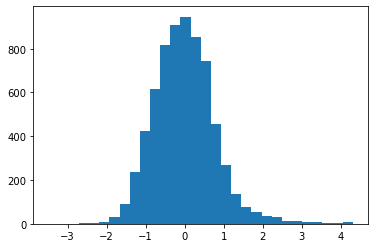

In [100]:
plt.hist(preds, 30);

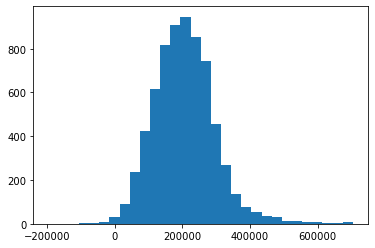

In [101]:
preds_rescaled = preds*ystd + ymean
plt.hist(preds_rescaled, 30);

# 2. Logistic regression

Ridge regression is not appropriate when the outcome $Y$ is binary, i.e. $y_i \in \{0,1\}$. In this setting, there is only one possible stochastic model for $Y$: the Bernoulli random variable. Recall that the Bernoulli distribution has a single parameter $p$ that controls the probability of whether the outcome is equal to 1. In logistic regression, we wish to model the probability that $Y$ is equal to 1 *given* the observed features $X$, that is, we seek a model for the quantity

$$
p(Y= 1 | X).
$$

Of course, the probability that $Y=0$ can be obtained from the above by subtracting it from 1, as we must have 

$$
p(Y= 0 | X) + p(Y= 1 | X) = 1.
$$

The probability of an event is constrained to lie on the interval $[0,1]$. A linear function of the features alone will not satisfy this constraint. Instead, the linear form is composed with the *logistic function* to yield the model

$$
p(Y=1 | X) = \frac{\exp(\beta_0 + \beta^Tx)}{\exp(\beta_0 + \beta^Tx) + 1}.
$$

## 2.1 Estimation of the model parameters

Under the logistic regression model, the outcomes $y_i$ are independent observations of the Bernoulli random variable

$$
y_i \sim \text{Bern}(p_{x_i}),
$$

where

$$
p_{x_i} = p(y_i = 1 | x_i) = \frac{\exp(\beta_0 + \beta^Tx)}{\exp(\beta_0 + \beta^Tx) + 1}
$$

The likelihood of a single observation $(x, y)$ is then

$$
\mathcal{L}(\beta_0, \beta) = p(y | x) = \begin{cases} p_x & y = 1 \\ 1-p_x & y = 0 \end{cases} = p_x^y(1-p_x)^{(1-y)},
$$

so that the likelihood given a set of observations $\{(x_i, y_i)_{i=1}^n\}$ is 

$$
\mathcal{L}(\beta_0, \beta) = \prod_{i=1}^n p_{x_i}^{y_i}(1-p_{x_i})^{(1-{y_i})}
$$

and the corresponding log-likelihood is
$$
\ell(\beta_0, \beta) = \sum_{i=1}^n y_i \log p_{x_i} + (1-y_{i}) \log (1-p_{x_i}). 
$$

As in the case of linear regression, we typically augment this objective function with a penalty term:

$$
\ell_\lambda(\beta_0, \beta) = \sum_{i=1}^n \left[y_i \log p_{x_i} + (1-y_{i}) \log (1-p_{x_i}) \right] + \frac{1}{2} \lambda ||\beta||_2^2. 
$$


__Exercise 2.1__: Complete the code below to compute the (penalized) likelihood objective and its gradient.

In [102]:
def logreg_objective(beta, X, y, lam):
    '''
    This is a HW problem. The solution will be available in the HW3 solutions.
    '''
    return None

In [103]:
def logreg_grad(beta, X, y, lam):
    '''
    This is a HW problem. The solution will be available in the HW3 solutions.
    '''
    return None

For our code example, we'll return to the Penguins dataset. We'll consider the problem of predicting the species given the quantitative measurements in the data (i.e. bill length, bill depth, flipper length, and body mass).

In [64]:
from sklearn.linear_model import LogisticRegression

penguins = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv', 
            sep=',', header=0)
penguins.dropna(inplace=True)

In [65]:
X = penguins.drop(['species', 'island', 'sex'], axis=1)
X.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


In [66]:
y = penguins['species']=='Adelie'
y.sum()

146

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Xscale = StandardScaler().fit(X_train)
X_train_std = Xscale.transform(X_train)
X_test_std = Xscale.transform(X_test)

The two classes appear reasonably well-separated in terms of the features in `X_train`:

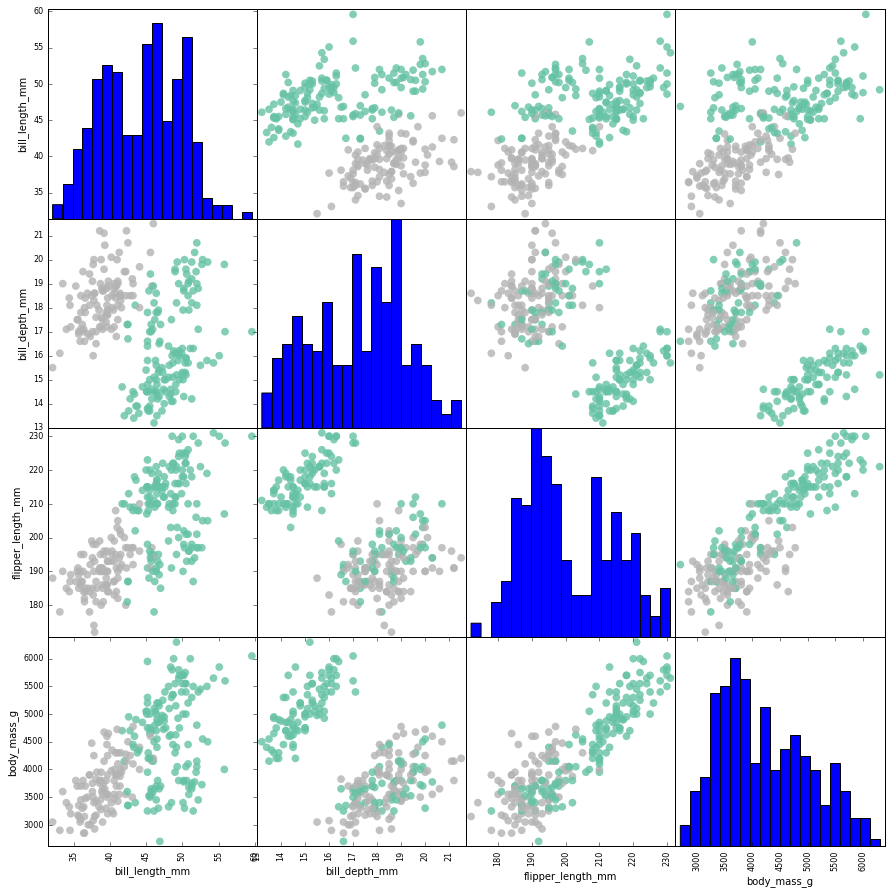

In [71]:
pd.plotting.scatter_matrix(X_train, c=y_train, figsize=(15, 15),
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8, cmap='Set2');

Logistic regression in `scikit-learn` is implemented through the `LogisticRegression()` object, which has the standard linear model API. 

__NOTE__: This implementation takes a different approach to penalization than what we have written above - see [here](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). If we wish to compare the `scikit-learn` results to our own implementaion, we first need to understand the relation between their parameter $C$ and our $\lambda$.

In [72]:
lr = LogisticRegression(C=0.1).fit(X_train_std, y_train)

In [73]:
probs = lr.predict_proba(X_train_std)
preds = lr.predict(X_train_std)

In [74]:
decision = probs[:,1]>0.5

In [75]:
np.array_equal(decision, preds)

True

__Exercise 2.2__: Use your own implementation of gradient descent and the gradient of the (penalized) logistic regression objective to estimate the model coefficients. Compare your results to the sklearn output above.

In [63]:
'''
This is a (slightly modified version of a) HW problem. 
Implementation details will be released in the HW3 solutions.
'''

'\nThis is a (slightly modified version of a) HW problem. \nImplementation details will be released in the HW3 solutions.\n'

## 2.2 Measuring classifier performance

There are a variety of ways to measure the peformance of a binary classifier. Given that for each example there are two possible predictions and two possible true labels, all prediction results belong to one of four cases. These are commonly referred to as `true positives` ($TP$), `true negatives` ($TN$), `false positives` ($FP$), and `false negatives` ($FN$), where "positive" and "negative" indicate the model prediction and "true" and "false" indicate whether the prediction was correct with respect to the actual label. These can be summarized in a two way table as follows:

In [76]:
results = pd.DataFrame({'Truth': y_train, 'Prediction': preds})

In [78]:
tt = results.groupby(['Truth', 'Prediction']).size().unstack().iloc[::-1, ::-1] # pandas version of R table()

tt

Prediction,True,False
Truth,,
True,104,2
False,7,136


Many binary classification metrics are simple functions of the values in this table. We have already seen one: the classification accuracy

$$
\text{Acc}(\hat{y}, y) = \frac{1}{n} \sum_{i=1}^n \mathbb{1}\{\hat{y}_i = y_i\}.
$$

In terms of the table above, this is obtained by computing the sum on the diagonal, then dividing by the sum over all cells in the table:

$$
\text{Acc}(\hat{y}, y) = \frac{TP + TN}{TP+FP+TN+FN}.
$$

Other metrics include:

`Precision`: $ \frac{TP}{TP+FP}$

`Recall`: (or sensitivity): $\frac{TP}{TP+FN}$

`Specificity`: $\frac{TN}{TN+FP}$

__Exercise 2.3__: Compute the precision, recall / sensitivity, and specificity of the logistic regression classifier on the test set.

In [80]:
## Solution
prec = tt.iloc[0,0] / tt.iloc[:,0].sum()
recall = tt.iloc[0,0] / tt.iloc[0,:].sum()
spec = tt.iloc[1,1] / tt.iloc[1,:].sum()

print('Precision: {:.3f}\n Recall: {:.3f}\nSpecificity: {:.3f}'.format(prec, recall, spec))

Precision: 0.937
 Recall: 0.981
Specificity: 0.951


## 2.3 Comparing classification algorithms

Finally, we consider the question of comparing two different classifiers from a statistical perspective. Suppose we train two classification models $M_1$ and $M_2$ on the training data and then generate predictions $\hat{y}_1$, $\hat{y}_2$, respectively, on a set of examples for which the true labels $y$ are known. We can produce a corresponding _contingency table_:


| | $M_2$ Inorrect | $M_2$ Correct |
| --- | --- | --- |
|$M_1$ Incorrect | $E_{00}$ | $E_{01}$ |
|$M_1$ Correct | $E_{10}$ | $E_{11}$

with
\begin{align*}
E_{00} &= \sum_{i=1}^n \mathbb{1}\{\hat{y}_{1i} \neq y_i\}\mathbb{1}\{\hat{y}_{2i} \neq y_i\} \\
E_{01} &= \sum_{i=1}^n \mathbb{1}\{\hat{y}_{1i} \neq y_i\}\mathbb{1}\{\hat{y}_{2i} = y_i\} \\
E_{10} &= \sum_{i=1}^n \mathbb{1}\{\hat{y}_{1i} = y_i\}\mathbb{1}\{\hat{y}_{2i} \neq y_i\} \\
E_{11} &= \sum_{i=1}^n \mathbb{1}\{\hat{y}_{1i} = y_i\}\mathbb{1}\{\hat{y}_{2i} = y_i\}
\end{align*}

We can frame the question of whether the methods have equal performance as a hypothesis test: under the null hypothesis that $M_1$ and $M_2$ have an equal error rate, we should have 

$$
E_{01} = E_{10} = \frac{E_{01} + E_{10}}{2}.
$$

We compute the test statistic

$$
\frac{\left(|E_{01} + E_{10}| - 1\right)^2}{E_{01} + E_{10}} \sim \chi_1^2
$$

which as indicated above is distributed as a chi-squared random variable with one degree of freedom. We reject the hypothesis of equal errors if this test statistic exceeds the corresponding critical value at some confidence level $(1-\alpha)$.

__Exercise 2.4:__ Train a k-nearest neighbors classifier (using the same features and label as above) and generate label predictions on the test set. Compare the results to that of logistic regression:

1. Generate the contingency table.
2. Compute the test statistic. 
3. State your conclusion regarding the hypothesis that the two algorithms have equal error rate.

In [88]:
# kNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_std, y_train) # the fit() method trains the model on the train data

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [89]:
# form truth table
knn_preds = knn.predict(X_train_std)
knn_results = pd.DataFrame({'Truth': y_train, 'Prediction': knn_preds})

knn_tt = knn_results.groupby(['Truth', 'Prediction']).size().unstack().iloc[::-1, ::-1] 
knn_tt # NaN in cell means there are no items in this category, i.e. is equiv to a zero

Prediction,True,False
Truth,,
True,106.0,NaN
False,2.0,141.0


In [92]:
# contingency table comparing LR and KNN predictions
lr_correct = preds==y_train
knn_correct = knn_preds==y_train

E00 = np.logical_and(~lr_correct, ~knn_correct).sum() # neither correct
E10 = np.logical_and(lr_correct, ~knn_correct).sum() # LR correct, KNN incorrect
E01 = np.logical_and(~lr_correct, knn_correct).sum() # KNN incorrect, LR correct
E11 = np.logical_and(lr_correct, knn_correct).sum() # both correct

In [93]:
test_stat = (np.abs(E10+E01)-1)**2/ (E10+E01)

test_stat

7.1111111111111107

In [95]:
from scipy.stats import chi2

# 1-sided p-value
1-chi2.cdf(test_stat, df=1)

# conclusion: we reject the null hypothesis that the methods have equal error

0.0076607611351794391

## 3. Gradient Descent with Adaptive Stepsize

In this section, we cover more of the mathematical intuition behind gradient descent, and propose the first of many improvements to the algorithm: an adaptive stepsize.

### 3.1. Directional Derivatives

Recall that for a function $f: \mathbb{R}^d \rightarrow \mathbb{R}$, the **gradient** $\nabla f(x) \in \mathbb{R}^d$ at point $x = (x_1, ..., x_n)^\top \in \mathbb{R}^d$ is defined as
$$
\nabla f(x) = \begin{bmatrix}
\frac{\partial}{\partial x_1} f(x)\\
\vdots\\
\frac{\partial}{\partial x_d} f(x)
\end{bmatrix},
$$
where $\frac{\partial}{\partial x_j} f(x)$ denotes the *partial derivative* of $f$ evaluated at $x$. For example, for $f(x) = x_1^3 + 4x^2_2 + x_1x_2$, the gradient (for general $x$) is
$$
\nabla f(x) = \begin{bmatrix}
\frac{\partial}{\partial x_1} f(x)\\
\frac{\partial}{\partial x_2} f(x)
\end{bmatrix}
=
\begin{bmatrix}
3x_1^2 + x_2\\
8x_2 + x_1
\end{bmatrix}
$$

The gradient seems like a natural generalization of the derivative for functions of multiple variables. However, we have the interpretation of the univariate derivative $\frac{d}{dx}f(x)$ as the slope of the tangent line at $(x, f(x))$. Do we have something similar for gradients of functions of multiple variables?

While there is no particular tangent line to a multivariate function, we can talk about *the tangent line of a function in a particular direction.* In the plot below, dashed lines on the $xy$-plane represent *directions*, and the solid line direct above those directions is a tangent line of the function at a point.
![directional_derivative](img/direction.png)
The slope of this line can be interpreted as the *rate of change* of the function along a particular direction. What is the value of this slope?

Let $p$ be a direction, represented by a a unit vector in $\mathbb{R}^d$, and let $x \in \mathbb{R}^d$ be the point at which we want to find the tangent line in the direction of $p$. The line along $p$ that crosses $x$ can be written as
$$
l(\eta) = x + \eta p
$$
Small values of $\eta$ indicate points on the line that are close to $x$, and large values indicate points on the line that are far from $x$. Then, we can talk about the value of the function $f$ along that line.
$$
f(l(\eta)) = f(x + \eta p)
$$
This represents the solid curves along the surface of the functions in the picture above. Note that this is curve is a function of a single variable: $\eta$. It should also be clear that the slope of the tangent line at $x$ will end up being the derivative of $f(l(\eta))$ evaluated at $\eta = 0$. Let's take this derivative.
$$
\begin{align*}
\frac{d}{d\eta} f(l(\eta)) &= \frac{d}{d\eta} f(x + \eta p) \\
&= \nabla f(x + \eta p)^\top \frac{d}{d\eta} x + \eta p \\
&= \nabla f(x + \eta p)^\top p
\end{align*}
$$
Evaluating this at $\eta = 0$ give us
$$
\nabla f(x)^\top p
$$
Thus, the slope of the tangent line at $x$ in the direction $p$ is given by $\nabla f(x)^\top p$. This value is called the **directional derivative** of $f$ at $x$ along $p$. Similarly, a unit vector $p$ is called a **descent direction** if the direction derivative along $p$ is negative. It may seem like the gradient helps us understand the directional derivative, but in fact it is often the opposite: the directional derivative can help us better understand the gradient.

Observe the contour plot below. We are visualizing a function $f(x_1, x_2)$ on $\mathbb{R}^2$ using *contour lines*. Each line represents a set of points in $\mathbb{R}^2$ that all have the same function value. If we drew the tangent line of any of these contours at some point, what would the directional derivative be along that line? (*Hint:* the function value is unchanging along these curves.)
![Gradient](img/contour.png)
What ever the gradient at $x_0$ is, it must satisfy $\nabla f(x_0)^\top p_1 = 0$ (likewise for $p_2$). Therefore, it must be a vector *orthogonal* to the tangent line at $x_0$. Why does it go in the particular direction shown in the plot? Let's take the directional derivative *in the direction of the gradient* (i.e. $p = \nabla f(x)$). 
$$
\begin{align*}
\nabla f(x)^\top p = \nabla f(x)^\top \nabla f(x) = ||\nabla f(x)||_2^2 = \sum_{j=1}^d \left(\nabla f(x)_j\right)^2 \geq 0
\end{align*}
$$
Thus the gradient cannot be a descent direction! Assuming the function is descending as it gets closer to the center, we are assured that we drew the gradient correctly.

### 3.2. Line Search Methods

The concept of descent direction leads naturally to an iterative algorithm for optimizing a function. If $p_0$ is a descent direction $x_0$, we could take a small $\eta_0$-sized step toward $x_0 + \eta_0p_0$. Call this new point $x_1$, find a new descent direction $p_1$, take an $\eta_1$ sized step toward $x_1 + \eta_1p_1$, and repeat the process.

1. Initialize $x_0$ randomly.
2. For $t = 0, 1, 2, ...$ until convergence: 
    1. Select $p_t$.
    2. Select $\eta_t$
    3. Update $x_{t+1} = x_{t} + \eta_{t} p_{t}$.

This method is called a **line search** method, because for every point $x_t$, we are searching for the next point along the line given by $l(\eta_t) = x_t + \eta_t p_t$. Gradient descent from the previous lab is a special case of line search, with $\eta_t = \eta$ is a constant *stepsize*, and $p_t = -\nabla f(x_t)$. Rewriting the update with these values, we get:
$$
\begin{align*}
    x_{t+1} &= x_{t} + \eta_{t} p_{t}\\
    &= x_{t} - \eta \nabla f(x_t)
\end{align*}
$$
Note that $p_t = -\nabla f(x_t)$ is guaranteed to be a descent direction if any of the entries of $\nabla f(x_t)$ are nonnegative, because
$$
\nabla f(x_t)^\top p_t = \nabla f(x_t)^\top \left(-\nabla f(x_t)\right) = - \nabla f(x_t)^\top \nabla f(x_t) = -||\nabla f(x_t)||_2^2 \leq 0.
$$

The success of a line search method depends on effective choices of both the descent direction $p_t$ and the stepsize $\eta_t$. Much of optimization research is dedicated to selection procedures. Note that certain procedures for selecting descent directions go well with certain procedures for selecting stepsizes; these decisions are not independent of each other.

In the plot below, we generate (unstandardized) data, and plot the linear regression objective. The arrow indicates the direction of the negative gradient at the initial point. Which way is it point with respect to the minimum?

In [118]:
def ill_conditioned_data(n, d, beta):
    X = np.random.normal(size=(n,d)) 
    X[:, 0] *= 10
    y = np.dot(X, beta) + np.random.normal(size=n)
    
    return X, y

In [119]:
np.random.seed(123)
n = 20
d = 2
beta = np.array([4.0, -2.0])

X, y = ill_conditioned_data(n, d, beta)

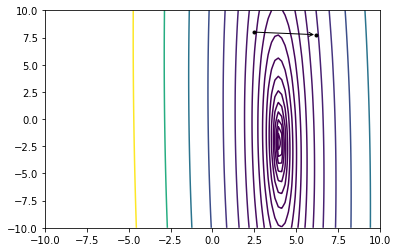

In [120]:
beta_init = np.array([2.5, 8])
eta = 0.01 ## <YOUR CODE HERE>
max_iter = 1 ## <YOUR CODE HERE>

iterates = graddescent(beta_init, eta, X, y, max_iter=max_iter)
plot_objective(X, y, iterates=iterates)

**Exercise 3.1**: In the code above, increase the `max_iter` parameter to see a few more iterates of gradient descent, at the same `eta`. What do you observe?

In [ ]:
# Solution here is just to play around with the parameter settings above.

**Exercise 3.2**: Now tune both the stepsize `eta` and the `max_iter` parameters until you can get gradient descent to converge to the minimum. How many iterations does it take?

In [ ]:
# Same for this one.

Now, we start at the same initialization, but standardize the data before performing the optimization. Once again, let us look at one iteration to look at the direction of the gradient. Where is it point in relation to the minimum?

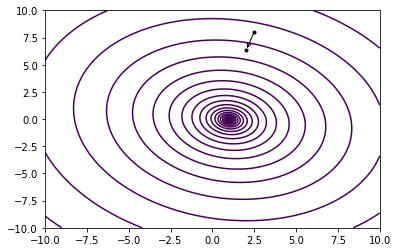

In [121]:
Xs, ys = standardize(X, y)

beta_init = np.array([2.5, 8])
eta = 0.1 ## <YOUR CODE HERE>
max_iter = 1 ## <YOUR CODE HERE>

iterates = graddescent(beta_init, eta, Xs, ys, max_iter=max_iter)

plot_objective(Xs, ys, iterates=iterates)

**Exercise 3.3**: Tune the `eta` and `max_iter` parameters to get gradient descent to converge for this example. How many iterations does it take?

There are two main takeaways.
- While $p_t = -\nabla f(x_t)$ may be the steepest descent direction, this is only true for a small region around $x_t$. For the overall path to the optimum, the negative gradient may be a terrible choice for a descent direction.
- Standardization is not only helpful for interpretablility and numerical stability. It actually changes the shape of the objective function so that the negative gradient *does* end up being a pretty decent choice for $p_t$.

For this reason, we will defer the question of picking $p_t$ for now, and settle for the negative gradient. We now focus on the question of automatically choosing a stepsize $\eta_t$. Both theory and intuition support the idea that *adapting* the stepsize depending on the iteration can yield numerous benefits. 

### 3.3. The Stepsize and Directional Derivative

As you saw in the previous exercises, we can run into issues when the stepsize is too big or too small.
![big](img/too_big.png)
If the stepsize is too large:
- Iterates can pass over the minimum, and the objective value can even *increase*.
- The increase can even cause numerical overflow.
- Similarly, this can also cause the algorithm to *cycle* between the same iterates, bouncing back and forth across a minimum, as shown in the plot.

![small](img/too_small.png)
If the stepsize is too small:
- This can cause a computational issue, in that the optimization algorithm will take way too long. 
- An even more subtle issue is when the stepsize decreases too quickly, and the algorithm stops making progress before reaching anywhere close to a minimum, as shown in the plot.

Can we automatically select a good stepsize for a given iteration?

A key observation is that will underly our stepsize choice is that *the descent in the function should be proportional to the directional derivative*. 

- Using the plot above, notice that at steep points in the curve (i.e. the directional derivative has large magnitude) we should make a step that decreases the function by a large amount. The intuition is that at the minimum, the derivative will be zero, so this large negative derivative means that there is a long way to go. 
- Similarly, when the directional derivative is small, we must be getting closer to the minimum, so we should tune the stepsize toward incremental changes in the function value. 

Thus, the magnitude of decrease should "match" the magnitude of the directional derivative. This proportionality enforced by the so-called **sufficient decrease condition**. Given a hyperparameter $c \in (0, 1)$, we choose the stepsize so that
$$
f(x_t + \eta_t p_t) - f(x_t) \leq c \eta_t \nabla f(x_t)^\top p_t
$$
Note that $\nabla f(x_t)^\top p_t < 0$. $c$ is the proportionality constant.

It can be proved (by way of multivariate Taylor series) that once $\eta_t$ is small enough, the sufficient decrease condition will *always be satisfied*. We just need to ensure that our stepsize smaller than some unknown upper bound. That being said, we want the stepsize to be as close to the upepr bound as possible, because bigger stepsizes generally mean more progress.

This suggest a natural procedure to pick the stepsize - a **back-tracking algorithm**.

1. Set large initial $\bar{\eta}$, decay rate $r \in (0, 1)$, $c \in (0, 1)$, and $\eta_t := \bar{\eta}$.
2. Until $f(x_t + \eta_t p_t) - f(x_t) \leq c \eta_t \nabla f(x_t)^\top p_t$, update $\eta_t := r \eta_t$.

This algorithm produces a stepsize that satisfies the sufficient decrease condition by construction, but is not too small, as it is only a factor $\frac{1}{r}$ away from violating this condition by being too big. Combining gradient descent with backtracking, we have constructed the **backtracking line search** algorithm.

**Exercise 3.4**: Implement the backtracking algorithm.

In [122]:
## <YOUR CODE HERE>
def backtracking(eta_init, decay_rate, prop_constant, f, f_grad, x, p):
    """Backtracking algorithm for stepsize selection.

	Parameters
	----------
	eta_init : float
		A positive number representing the starting, maximum stepsize.
    decay_rate : float
		A number in (0, 1) indicating how much to decrease eta while backtracking.
    prop_constant : float
		A number the proportionality between the amount of descent and directional derivative.
    f : function
		An objective function that maps a numpy array to a float.
    f_grad : function
		A function that computes the gradient of f at a point x. 
        Maps a 1D numpy array to a numpy array of the same size.
    x : numpy.ndarray
		A 1D array representing a point in d-dimensional space.
    p : numpy.ndarray
		A 1D array (unit vector) representing a direction in d-dimensional space.

	Returns
	-------
	eta : float
		The first eta value that satisfies the sufficient decrease condition.
	"""
    
    eta = eta_init
    
    def sufficient_decrease(eta):
        return f(x + eta * p) - f(x) <= prop_constant * eta * np.dot(f_grad(x), p)
    
    while not sufficient_decrease(eta):
        eta *= decay_rate
    
    return eta

**Exercise 3.5**: Implement the backtracking line search algorithm.

In [123]:
def backtracking_line_search(x_init, eta_init, decay_rate, prop_constant, f, f_grad, max_iter=20):
    """Backtracking line search for optimization.

	Parameters
	----------
    x_init : numpy.ndarray
		Initial solution.
	eta_init : float
		A positive number representing the starting, maximum stepsize.
    decay_rate : float
		A number in (0, 1) indicating how much to decrease eta while backtracking.
    prop_constant : float
		A number the proportionality between the amount of descent and directional derivative.
    f : function
		An objective function that maps a numpy array to a float.
    f_grad : function
		A function that computes the gradient of f at a point x. 
        Maps a 1D numpy array to a numpy array of the same size.
    max_iter : int
		A positive integer containing the maximum number of iterations for the outer loop.

	Returns
	-------
	iterates : list
		A list of numpy arrays containing the iterates of the algorithm.
	"""
    x = x_init
    iterates = [x_init]

    for t in range(max_iter):
        
        # Pick search direction.
        p = -f_grad(x) ## <YOUR CODE HERE>
        
        # Pick stepsize.
        eta = backtracking(eta_init, decay_rate, prop_constant, f, f_grad, x, p) ## <YOUR CODE HERE>
        
        # Perform update.
        x = x + eta*p ## <YOUR CODE HERE>
        
        iterates.append(x)
        
    return iterates

**Exercise 3.6**: Implement the gradient of the function `f` given below.

In [124]:
def f(x):
    x1 = x[0]
    x2 = x[1]
    
    return 10*(x2 - x1**2)**2 + (x1 - 1)**2

def f_grad(x):
    """Gradient of f.

	Parameters
	----------
    x_init : numpy.ndarray
		Size 2 array, point at which to evaluate.

	Returns
	-------
	grad : numpy.ndarray
		The gradient, same size as x.
	"""
    x1 = x[0]
    x2 = x[1]
    
    grad = np.array([20*(x2 - x1**2)*(-2*x1) + 2*(x1 - 1), 20*(x2 - x1**2)])
    
    return grad

In [125]:
def gradient_descent(x_init, eta, f_grad, max_iter=20):
    """Backtracking line search for optimization.

	Parameters
	----------
    x_init : numpy.ndarray
		Initial solution.
	eta : float
		Stepsize.
    f_grad : function
		A function that computes the gradient of f at a point x. 
        Maps a 1D numpy array to a numpy array of the same size.
    max_iter : int
		A positive integer containing the maximum number of iterations for the outer loop.

	Returns
	-------
	iterates : list
		A list of numpy arrays containing the iterates of the algorithm.
	"""
    x = x_init
    iterates = [x_init]

    for t in range(max_iter):
        x = x - eta * f_grad(x)        
        iterates.append(x)
        
    return iterates

def plot_f(f, iterates):
    nb = 100
    brange = np.linspace(-1.5, 1.5, nb)
    b1, b2 = np.meshgrid(brange, brange)
    z = np.array([f(x) for x in zip(b1.ravel(), b2.ravel())])
    
    levels=np.logspace(-2,5,30)
    
    plt.contour(brange, brange, z.reshape((nb, nb)), levels=levels);
    
    # Points.
    xy = np.array(iterates)
    plt.plot(xy[:,0], xy[:,1], 'k.');

    # Arrows.
    for j in range(1, len(iterates)):
        plt.annotate(
            "",
            xy=iterates[j],
            xytext=iterates[j - 1],
            arrowprops={"arrowstyle": "->", "color": "k", "lw": 1},
            va="center",
            ha="center",
        )

**Exercise 3.7**: Use the code below to plot the sequence of iterates for backtracking line search and gradient descent. (Do not change the initialization `x_init`. Tune the hyperparameters to get them both to converge. How does backtracking compare to gradient descent?

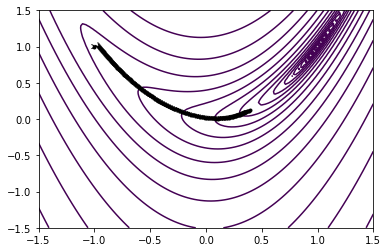

In [126]:
x_init = np.array([-1, 1])
eta = 0.01
max_iter = 100

iters_gd = gradient_descent(x_init, eta, f_grad, max_iter=max_iter)

plot_f(f, iters_gd)

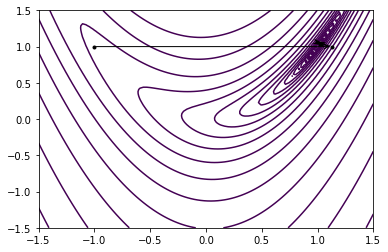

In [127]:
x_init = np.array([-1, 1])

try:
    max_iter = 5
    prop_constant = 0.3
    decay_rate = 0.9
    eta_init = 1

    iters_btls = backtracking_line_search(x_init, eta_init, decay_rate, prop_constant, f, f_grad, max_iter=max_iter)
    plot_f(f, iters_btls)
except KeyboardInterrupt:
    print("Graceful Exit")